In [14]:
# First, clear the mount point and remount Google Drive
import os
import shutil
from google.colab import drive

# Safely unmount and clear the directory if it exists
try:
    # Attempt to unmount if already mounted
    if os.path.ismount('/content/drive'):
        !fusermount -u /content/drive

    # Remove the directory if it exists
    if os.path.exists('/content/drive'):
        shutil.rmtree('/content/drive')

    # Create fresh mount point
    os.makedirs('/content/drive')
except Exception as e:
    print(f"Error during cleanup: {str(e)}")

# Mount Google Drive
drive.mount('/content/drive')

import os
import random
import torch
import torchvision
import pandas as pd
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
from functools import partial
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
import pickle
from typing import Dict, List, Tuple
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
warnings.filterwarnings("ignore")

# Set style for all plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 12

# Define global variables with updated classes and paths
SELECTED_CLASSES = ['person', 'car', 'dog', 'chair', 'bird', 'tvmonitor', 'motorbike', 'bus']
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.0003
IMAGE_SIZE = 256
BASE_DIR = '/content/drive/MyDrive/VOC_Dataset/processed_data'
OUTPUT_DIR = os.path.join(BASE_DIR, 'model_outputs')

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

class CachedVOCDataset(Dataset):
    def __init__(
        self,
        image_dir: str,
        annotation_file: str,
        transform=None,
        cache_dir: str = None,
        preload_memory: bool = False,
        num_workers: int = 4
    ):
        super().__init__()
        self.image_dir = image_dir
        self.transform = transform
        self.preload_memory = preload_memory
        self.cache_dir = cache_dir or os.path.join(os.path.dirname(image_dir), 'cache')
        os.makedirs(self.cache_dir, exist_ok=True)

        # Load annotations
        self.data = pd.read_csv(annotation_file)
        self._verify_and_clean_data(num_workers)

        # Initialize caches
        self.image_cache: Dict[str, torch.Tensor] = {}
        self.cache_file = os.path.join(self.cache_dir, 'image_cache.pkl')

        if preload_memory:
            self._preload_images(num_workers)

    def _verify_and_clean_data(self, num_workers: int) -> None:
        """Verify images exist and are valid in parallel."""
        def verify_image(row) -> Tuple[int, bool]:
            img_path = os.path.join(self.image_dir, row['image_name'])
            try:
                with Image.open(img_path) as img:
                    img.verify()
                return row.name, True
            except:
                return row.name, False

        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(executor.map(verify_image, [row for _, row in self.data.iterrows()]))

        valid_indices = [idx for idx, valid in results if valid]
        self.data = self.data.loc[valid_indices].reset_index(drop=True)

    def _preload_images(self, num_workers: int) -> None:
        if os.path.exists(self.cache_file):
            print(f"Loading cached images from {self.cache_file}")
            with open(self.cache_file, 'rb') as f:
                self.image_cache = pickle.load(f)
            return

        print("Preloading images into memory cache...")
        def load_image(img_name: str) -> Tuple[str, torch.Tensor]:
            img_path = os.path.join(self.image_dir, img_name)
            try:
                with Image.open(img_path).convert('RGB') as img:
                    if self.transform:
                        img_tensor = self.transform(img)
                    else:
                        img_tensor = transforms.ToTensor()(img)
                return img_name, img_tensor
            except Exception as e:
                warnings.warn(f"Failed to load {img_path}: {str(e)}")
                return img_name, None

        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(tqdm(
                executor.map(load_image, self.data['image_name']),
                total=len(self.data),
                desc="Preloading images"
            ))

        self.image_cache = {name: tensor for name, tensor in results if tensor is not None}

        print(f"Saving image cache to {self.cache_file}")
        with open(self.cache_file, 'wb') as f:
            pickle.dump(self.image_cache, f)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        img_name = self.data.iloc[idx]['image_name']

        if self.preload_memory and img_name in self.image_cache:
            image = self.image_cache[img_name]
        else:
            try:
                img_path = os.path.join(self.image_dir, img_name)
                with Image.open(img_path).convert('RGB') as img:
                    image = self.transform(img) if self.transform else transforms.ToTensor()(img)
            except Exception as e:
                warnings.warn(f"Error loading image {img_path}: {str(e)}")
                image = torch.zeros((3, IMAGE_SIZE, IMAGE_SIZE))

        labels = torch.tensor([
            self.data.iloc[idx][class_name] for class_name in SELECTED_CLASSES
        ], dtype=torch.float32)

        return image, labels

class ImprovedMultiLabelClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedMultiLabelClassifier, self).__init__()

        # Use EfficientNet-B2 as backbone
        self.backbone = torchvision.models.efficientnet_b2(weights='DEFAULT')
        backbone_out_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        # Advanced classifier head
        self.classifier = nn.Sequential(
            nn.Linear(backbone_out_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

    def unfreeze_layers(self, from_layer=6):
        # Freeze backbone initially
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Unfreeze last few layers of backbone
        for param in list(self.backbone.children())[-from_layer:]:
            for p in param.parameters():
                p.requires_grad = True

        # Always train classifier
        for param in self.classifier.parameters():
            param.requires_grad = True

def check_tpu_status():
    """Check TPU availability and print detailed information."""
    try:
        import torch_xla
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
        print("\nTPU Information:")
        print(f"TPU Device: {device}")
        print("TPU is available and configured correctly")
        return device
    except Exception as e:
        print("\nWARNING: No TPU detected! Error:", str(e))
        print("\nFalling back to GPU/CPU...")
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def create_optimized_dataloaders(
    train_img_dir: str,
    val_img_dir: str,
    train_annotations: str,
    val_annotations: str,
    batch_size: int,
    num_workers: int,
    cache_dir: str = None,
    preload_memory: bool = False
) -> Tuple[DataLoader, DataLoader]:
    """Create optimized data loaders with enhanced augmentation."""

    # Enhanced data augmentation for training
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE + 32, IMAGE_SIZE + 32)),  # Larger resize for random crop
        transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomGrayscale(p=0.05),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Validation transform
    val_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    train_dataset = CachedVOCDataset(
        image_dir=train_img_dir,
        annotation_file=train_annotations,
        transform=train_transform,
        cache_dir=cache_dir,
        preload_memory=preload_memory,
        num_workers=num_workers
    )

    val_dataset = CachedVOCDataset(
        image_dir=val_img_dir,
        annotation_file=val_annotations,
        transform=val_transform,
        cache_dir=cache_dir,
        preload_memory=preload_memory,
        num_workers=num_workers
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2,
        drop_last=True
    )

    return train_loader, val_loader

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device,
                patience=7, min_delta=0.001):
    """Enhanced training function with mixed precision and learning rate scheduling."""
    best_val_f1 = 0
    train_losses = []
    val_metrics = {'f1': []}

    counter = 0
    early_stop = False

    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler()

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    criterion = criterion.to(device)
    is_tpu = str(device).startswith('xla')

    for epoch in range(num_epochs):
        if early_stop:
            print(f"\nEarly stopping triggered after epoch {epoch}")
            break

        model.train()
        running_loss = 0.0

        if is_tpu:
            train_device_loader = pl.ParallelLoader(train_loader, [device]).per_device_loader(device)
        else:
            train_device_loader = train_loader

        for images, labels in tqdm(train_device_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            try:
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Use mixed precision training
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                if is_tpu:
                    xm.mark_step()

                running_loss += loss.item()

            except Exception as e:
                print(f"Error in training batch: {str(e)}")
                continue

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {epoch_loss:.4f}')

        val_f1 = evaluate_model(model, val_loader, device, plot_results=False)
        val_metrics['f1'].append(val_f1)

        # Learning rate scheduling
        scheduler.step(val_f1)

        if val_f1 > best_val_f1 + min_delta:
            counter = 0
            best_val_f1 = val_f1

            model_path = os.path.join(OUTPUT_DIR, 'best_model.pth')
            if is_tpu:
                xm.save(model.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)

            print(f"New best validation F1: {best_val_f1:.4f}")
        else:
            counter += 1
            print(f"EarlyStopping counter: {counter} out of {patience}")

            if counter >= patience:
                early_stop = True
                print("Early stopping triggered")
                break

    return train_losses, val_metrics, epoch + 1

Mounted at /content/drive


In [19]:
def evaluate_model(model, dataloader, device, plot_results=False):
    """Evaluate the model with multiple metrics and display results."""
    model.eval()
    all_preds = []
    all_labels = []
    is_tpu = str(device).startswith('xla')

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images)

            if is_tpu:
                import torch_xla.core.xla_model as xm
                xm.mark_step()
                outputs = outputs.cpu()
            else:
                outputs = outputs.cpu()

            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities >= 0.5).float()
            all_preds.extend(predictions.numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Print per-class metrics
    print("\nPer-class Metrics:")
    print("-" * 50)
    print(f"{'Class':<10} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
    print("-" * 50)

    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    if plot_results:
        # Calculate number of rows needed for all classes
        num_classes = len(SELECTED_CLASSES)
        num_cols = 3  # We'll show 3 classes per row
        num_rows = (num_classes + num_cols - 1) // num_cols
        plt.figure(figsize=(15, 5 * num_rows))

    for i, class_name in enumerate(SELECTED_CLASSES):
        acc = accuracy_score(all_labels[:, i], all_preds[:, i])
        prec = precision_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        rec = recall_score(all_labels[:, i], all_preds[:, i], zero_division=0)
        f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)

        # Print metrics for each class
        print(f"{class_name:<10} {acc:>10.3f} {prec:>10.3f} {rec:>10.3f} {f1:>10.3f}")

        metrics['accuracy'].append(acc)
        metrics['precision'].append(prec)
        metrics['recall'].append(rec)
        metrics['f1'].append(f1)

        if plot_results:
            plt.subplot(num_rows, num_cols, i + 1)
            metric_values = [acc, prec, rec, f1]
            metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']
            plt.bar(metric_names, metric_values)
            plt.title(f'{class_name}')
            plt.ylim(0, 1)
            plt.xticks(rotation=45)

    if plot_results:
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'final_metrics.png'), bbox_inches='tight', dpi=300)
        plt.close()

    print("-" * 50)
    print(f"Average Metrics:")
    print(f"Accuracy:  {np.mean(metrics['accuracy']):.3f}")
    print(f"Precision: {np.mean(metrics['precision']):.3f}")
    print(f"Recall:    {np.mean(metrics['recall']):.3f}")
    print(f"F1-Score:  {np.mean(metrics['f1']):.3f}")

    return np.mean(metrics['f1'])

# Add function to display predictions
def display_predictions(model, dataloader, device, num_images=6):
    """Display predictions for random images that contain trained labels."""
    model.eval()

    # Initialize lists to store candidates
    candidates = {
        'images': [],
        'labels': []
    }

    # Collect candidate images that have at least one of the trained labels
    for images, labels in dataloader:
        for img, label in zip(images, labels):
            # Check if image has any of our trained labels
            if torch.any(label > 0):  # Contains at least one positive label
                candidates['images'].append(img)
                candidates['labels'].append(label)

        if len(candidates['images']) >= num_images * 3:  # Get enough candidates
            break

    # Convert candidates to tensors
    candidate_images = torch.stack(candidates['images'])
    candidate_labels = torch.stack(candidates['labels'])

    # Randomly select from candidates
    total_candidates = len(candidate_images)
    if total_candidates < num_images:
        print(f"Warning: Only found {total_candidates} images with relevant labels")
        num_images = total_candidates

    random_indices = torch.randperm(total_candidates)[:num_images]

    # Select random images and labels from candidates
    images = candidate_images[random_indices]
    labels = candidate_labels[random_indices]

    with torch.no_grad():
        images_device = images.to(device)
        outputs = model(images_device)
        if str(device).startswith('xla'):
            import torch_xla.core.xla_model as xm
            xm.mark_step()
            outputs = outputs.cpu()
        else:
            outputs = outputs.cpu()

        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities >= 0.5).float()

    # Create grid of images
    rows = (num_images + 2) // 3  # Calculate needed rows
    cols = min(3, num_images)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.ravel()

    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    denorm = transforms.Normalize(-mean/std, 1.0/std)

    for idx, (img, pred, label) in enumerate(zip(images, predictions, labels)):
        # Denormalize and convert to numpy
        img_display = denorm(img).permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        # Display image
        axes[idx].imshow(img_display)

        # Create prediction text
        pred_classes = [SELECTED_CLASSES[i] for i, p in enumerate(pred) if p > 0.5]
        true_classes = [SELECTED_CLASSES[i] for i, l in enumerate(label) if l > 0.5]

        pred_text = "Pred: " + ", ".join(pred_classes) if pred_classes else "Pred: none"
        true_text = "True: " + ", ".join(true_classes) if true_classes else "True: none"

        axes[idx].set_title(f"{pred_text}\n{true_text}", fontsize=8)
        axes[idx].axis('off')

    # Turn off any unused subplots
    for idx in range(len(images), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

def plot_training_history(train_losses, val_metrics):
    """Plot training history with improved visualization."""
    plt.figure(figsize=(15, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot validation F1 score
    plt.subplot(1, 2, 2)
    plt.plot(val_metrics['f1'], 'r-', label='Validation F1')
    plt.title('Validation F1 Score Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()  # Display plot in notebook
    plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), bbox_inches='tight', dpi=300)
    plt.close()

In [10]:
# Device setup
device = xm.xla_device()
has_tpu = check_tpu_status()

# Set up data directories
TRAIN_IMG_DIR = os.path.join(BASE_DIR, 'train/images')
VAL_IMG_DIR = os.path.join(BASE_DIR, 'val/images')
TRAIN_ANNOTATIONS = os.path.join(BASE_DIR, 'train_annotations.csv')
VAL_ANNOTATIONS = os.path.join(BASE_DIR, 'val_annotations.csv')

os.makedirs(OUTPUT_DIR, exist_ok=True)


TPU Information:
TPU Device: xla:0
TPU is available and configured correctly


In [16]:
# Create optimized dataloaders
print("\nInitializing data loaders...")
train_loader, val_loader = create_optimized_dataloaders(
    train_img_dir=TRAIN_IMG_DIR,
    val_img_dir=VAL_IMG_DIR,
    train_annotations=TRAIN_ANNOTATIONS,
    val_annotations=VAL_ANNOTATIONS,
    batch_size=BATCH_SIZE,
    num_workers=4 if has_tpu else 2,
    cache_dir=os.path.join(BASE_DIR, 'cache'),
    preload_memory=True  # Set to False if memory is limited
)

# Dataset information
print("\nDataset Information:")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Selected classes: {SELECTED_CLASSES}")
print(f"Using device: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}\n")


Initializing data loaders...
Preloading images into memory cache...


Preloading images: 100%|██████████| 5717/5717 [00:34<00:00, 165.97it/s]


Saving image cache to /content/drive/MyDrive/VOC_Dataset/processed_data/cache/image_cache.pkl
Loading cached images from /content/drive/MyDrive/VOC_Dataset/processed_data/cache/image_cache.pkl

Dataset Information:
Number of training batches: 178
Number of validation batches: 110
Selected classes: ['person', 'car', 'dog', 'chair', 'bird', 'tvmonitor', 'motorbike', 'bus']
Using device: xla:0
Batch size: 32
Number of epochs: 30
Learning rate: 0.0003



In [17]:
# Initialize model and move to device
model = ImprovedMultiLabelClassifier(len(SELECTED_CLASSES))
model = model.to(device)

# Initialize criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Train the model
train_losses, val_metrics, epochs_run = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=device
)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 170MB/s]
Epoch 1/30: 178it [05:52,  1.98s/it]



Epoch 1/30:
Training Loss: 1.2494


Evaluating: 100%|██████████| 110/110 [00:27<00:00,  3.94it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.868      0.944      0.733      0.825
car             0.918      0.614      0.579      0.596
dog             0.941      0.651      0.791      0.714
chair           0.910      0.562      0.632      0.595
bird            0.965      0.753      0.722      0.737
tvmonitor       0.930      0.405      0.874      0.554
motorbike       0.957      0.532      0.689      0.601
bus             0.963      0.491      0.880      0.630
--------------------------------------------------
Average Metrics:
Accuracy:  0.932
Precision: 0.619
Recall:    0.737
F1-Score:  0.657
New best validation F1: 0.6565


Epoch 2/30: 178it [03:33,  1.20s/it]



Epoch 2/30:
Training Loss: 0.4364


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.61it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.892      0.909      0.827      0.866
car             0.942      0.932      0.484      0.637
dog             0.962      0.777      0.836      0.806
chair           0.921      0.630      0.580      0.604
bird            0.984      0.960      0.805      0.876
tvmonitor       0.968      0.648      0.782      0.708
motorbike       0.974      0.685      0.832      0.751
bus             0.982      0.696      0.880      0.777
--------------------------------------------------
Average Metrics:
Accuracy:  0.953
Precision: 0.780
Recall:    0.753
F1-Score:  0.753
New best validation F1: 0.7533


Epoch 3/30: 178it [03:34,  1.21s/it]



Epoch 3/30:
Training Loss: 0.3015


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.79it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.902      0.929      0.832      0.878
car             0.947      0.857      0.587      0.697
dog             0.970      0.839      0.839      0.839
chair           0.919      0.609      0.616      0.612
bird            0.985      0.956      0.813      0.879
tvmonitor       0.981      0.853      0.736      0.790
motorbike       0.981      0.822      0.772      0.796
bus             0.988      0.809      0.880      0.843
--------------------------------------------------
Average Metrics:
Accuracy:  0.959
Precision: 0.834
Recall:    0.759
F1-Score:  0.792
New best validation F1: 0.7918


Epoch 4/30: 178it [03:30,  1.18s/it]



Epoch 4/30:
Training Loss: 0.2693


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.87it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.905      0.907      0.865      0.885
car             0.943      0.835      0.565      0.674
dog             0.975      0.895      0.830      0.862
chair           0.906      0.550      0.550      0.550
bird            0.983      0.969      0.776      0.862
tvmonitor       0.982      0.916      0.690      0.787
motorbike       0.982      0.814      0.814      0.814
bus             0.990      0.841      0.888      0.864
--------------------------------------------------
Average Metrics:
Accuracy:  0.958
Precision: 0.841
Recall:    0.747
F1-Score:  0.787
EarlyStopping counter: 1 out of 7


Epoch 5/30: 178it [03:32,  1.20s/it]



Epoch 5/30:
Training Loss: 0.2051


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.55it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.911      0.925      0.860      0.891
car             0.949      0.891      0.579      0.702
dog             0.970      0.842      0.842      0.842
chair           0.922      0.634      0.586      0.609
bird            0.987      0.945      0.855      0.898
tvmonitor       0.981      0.958      0.649      0.774
motorbike       0.980      0.778      0.820      0.799
bus             0.991      0.877      0.856      0.866
--------------------------------------------------
Average Metrics:
Accuracy:  0.961
Precision: 0.856
Recall:    0.756
F1-Score:  0.798
New best validation F1: 0.7977


Epoch 6/30: 178it [03:30,  1.18s/it]



Epoch 6/30:
Training Loss: 0.1747


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.86it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.915      0.935      0.859      0.895
car             0.951      0.858      0.641      0.734
dog             0.977      0.940      0.806      0.868
chair           0.915      0.581      0.665      0.620
bird            0.987      0.967      0.842      0.900
tvmonitor       0.983      0.967      0.678      0.797
motorbike       0.984      0.944      0.701      0.804
bus             0.991      0.885      0.864      0.874
--------------------------------------------------
Average Metrics:
Accuracy:  0.963
Precision: 0.885
Recall:    0.757
F1-Score:  0.812
New best validation F1: 0.8117


Epoch 7/30: 178it [03:33,  1.20s/it]



Epoch 7/30:
Training Loss: 0.1456


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.75it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.916      0.933      0.863      0.897
car             0.954      0.887      0.639      0.742
dog             0.974      0.884      0.830      0.856
chair           0.920      0.619      0.619      0.619
bird            0.984      0.947      0.817      0.878
tvmonitor       0.982      0.917      0.701      0.795
motorbike       0.983      0.908      0.713      0.799
bus             0.993      0.923      0.864      0.893
--------------------------------------------------
Average Metrics:
Accuracy:  0.963
Precision: 0.877
Recall:    0.756
F1-Score:  0.810
EarlyStopping counter: 1 out of 7


Epoch 8/30: 178it [03:32,  1.20s/it]



Epoch 8/30:
Training Loss: 0.1419


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.52it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.914      0.920      0.873      0.896
car             0.947      0.816      0.639      0.716
dog             0.973      0.870      0.833      0.851
chair           0.919      0.597      0.681      0.636
bird            0.985      0.947      0.822      0.880
tvmonitor       0.984      0.879      0.793      0.834
motorbike       0.984      0.868      0.784      0.824
bus             0.993      0.964      0.848      0.902
--------------------------------------------------
Average Metrics:
Accuracy:  0.962
Precision: 0.858
Recall:    0.784
F1-Score:  0.817
New best validation F1: 0.8175


Epoch 9/30: 178it [03:32,  1.20s/it]



Epoch 9/30:
Training Loss: 0.1119


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.85it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.921      0.927      0.883      0.905
car             0.945      0.778      0.668      0.719
dog             0.973      0.910      0.794      0.848
chair           0.918      0.599      0.654      0.625
bird            0.986      0.936      0.855      0.894
tvmonitor       0.983      0.848      0.799      0.822
motorbike       0.984      0.894      0.760      0.822
bus             0.993      0.930      0.856      0.892
--------------------------------------------------
Average Metrics:
Accuracy:  0.963
Precision: 0.853
Recall:    0.784
F1-Score:  0.816
EarlyStopping counter: 1 out of 7


Epoch 10/30: 178it [03:33,  1.20s/it]



Epoch 10/30:
Training Loss: 0.0985


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.84it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.912      0.924      0.863      0.892
car             0.949      0.836      0.636      0.722
dog             0.967      0.809      0.845      0.827
chair           0.916      0.587      0.673      0.627
bird            0.981      0.923      0.793      0.853
tvmonitor       0.980      0.771      0.851      0.809
motorbike       0.984      0.834      0.814      0.824
bus             0.994      0.965      0.872      0.916
--------------------------------------------------
Average Metrics:
Accuracy:  0.960
Precision: 0.831
Recall:    0.793
F1-Score:  0.809
EarlyStopping counter: 2 out of 7


Epoch 11/30: 178it [03:33,  1.20s/it]



Epoch 11/30:
Training Loss: 0.0853


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.73it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.913      0.930      0.859      0.893
car             0.947      0.855      0.595      0.702
dog             0.970      0.862      0.815      0.838
chair           0.924      0.633      0.657      0.644
bird            0.984      0.930      0.830      0.877
tvmonitor       0.984      0.927      0.730      0.817
motorbike       0.985      0.919      0.743      0.821
bus             0.990      0.870      0.856      0.863
--------------------------------------------------
Average Metrics:
Accuracy:  0.962
Precision: 0.866
Recall:    0.761
F1-Score:  0.807
EarlyStopping counter: 3 out of 7


Epoch 12/30: 178it [03:32,  1.19s/it]



Epoch 12/30:
Training Loss: 0.0765


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.57it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.914      0.902      0.893      0.898
car             0.947      0.789      0.671      0.725
dog             0.964      0.792      0.830      0.811
chair           0.917      0.587      0.681      0.631
bird            0.984      0.956      0.809      0.876
tvmonitor       0.980      0.787      0.828      0.807
motorbike       0.984      0.922      0.713      0.804
bus             0.992      0.930      0.848      0.887
--------------------------------------------------
Average Metrics:
Accuracy:  0.960
Precision: 0.833
Recall:    0.784
F1-Score:  0.805
EarlyStopping counter: 4 out of 7


Epoch 13/30: 178it [03:30,  1.18s/it]



Epoch 13/30:
Training Loss: 0.0640


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.53it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.923      0.943      0.871      0.906
car             0.947      0.783      0.677      0.726
dog             0.974      0.928      0.785      0.851
chair           0.924      0.640      0.616      0.628
bird            0.985      0.943      0.826      0.881
tvmonitor       0.985      0.880      0.799      0.837
motorbike       0.985      0.912      0.749      0.822
bus             0.993      0.932      0.880      0.905
--------------------------------------------------
Average Metrics:
Accuracy:  0.964
Precision: 0.870
Recall:    0.775
F1-Score:  0.819
New best validation F1: 0.8194


Epoch 14/30: 178it [03:31,  1.19s/it]



Epoch 14/30:
Training Loss: 0.0527


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.66it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.922      0.935      0.877      0.905
car             0.943      0.755      0.677      0.713
dog             0.971      0.865      0.818      0.841
chair           0.924      0.638      0.619      0.628
bird            0.986      0.936      0.846      0.889
tvmonitor       0.984      0.861      0.816      0.838
motorbike       0.983      0.831      0.796      0.813
bus             0.993      0.939      0.856      0.895
--------------------------------------------------
Average Metrics:
Accuracy:  0.963
Precision: 0.845
Recall:    0.788
F1-Score:  0.815
EarlyStopping counter: 1 out of 7


Epoch 15/30: 178it [03:29,  1.18s/it]



Epoch 15/30:
Training Loss: 0.0454


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.66it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.926      0.939      0.881      0.909
car             0.944      0.754      0.685      0.718
dog             0.973      0.901      0.797      0.846
chair           0.926      0.639      0.662      0.651
bird            0.988      0.942      0.871      0.905
tvmonitor       0.984      0.889      0.782      0.832
motorbike       0.985      0.939      0.737      0.826
bus             0.993      0.938      0.848      0.891
--------------------------------------------------
Average Metrics:
Accuracy:  0.965
Precision: 0.868
Recall:    0.783
F1-Score:  0.822
New best validation F1: 0.8221


Epoch 16/30: 178it [03:29,  1.18s/it]



Epoch 16/30:
Training Loss: 0.0426


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.63it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.919      0.924      0.881      0.902
car             0.945      0.770      0.674      0.719
dog             0.974      0.928      0.782      0.849
chair           0.922      0.643      0.559      0.598
bird            0.986      0.949      0.842      0.892
tvmonitor       0.984      0.842      0.828      0.835
motorbike       0.984      0.894      0.760      0.822
bus             0.994      0.991      0.840      0.909
--------------------------------------------------
Average Metrics:
Accuracy:  0.963
Precision: 0.868
Recall:    0.771
F1-Score:  0.816
EarlyStopping counter: 1 out of 7


Epoch 17/30: 178it [03:32,  1.19s/it]



Epoch 17/30:
Training Loss: 0.0344


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.60it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.921      0.952      0.857      0.902
car             0.949      0.844      0.633      0.724
dog             0.974      0.882      0.836      0.858
chair           0.920      0.607      0.659      0.632
bird            0.986      0.937      0.859      0.896
tvmonitor       0.984      0.833      0.833      0.833
motorbike       0.984      0.882      0.760      0.817
bus             0.991      0.873      0.880      0.876
--------------------------------------------------
Average Metrics:
Accuracy:  0.964
Precision: 0.851
Recall:    0.790
F1-Score:  0.817
EarlyStopping counter: 2 out of 7


Epoch 18/30: 178it [03:30,  1.18s/it]



Epoch 18/30:
Training Loss: 0.0334


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.63it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.919      0.930      0.875      0.902
car             0.943      0.749      0.679      0.712
dog             0.968      0.814      0.848      0.831
chair           0.920      0.615      0.632      0.624
bird            0.985      0.940      0.838      0.886
tvmonitor       0.982      0.837      0.799      0.818
motorbike       0.983      0.828      0.808      0.818
bus             0.994      0.948      0.872      0.908
--------------------------------------------------
Average Metrics:
Accuracy:  0.962
Precision: 0.833
Recall:    0.794
F1-Score:  0.812
EarlyStopping counter: 3 out of 7


Epoch 19/30: 178it [03:32,  1.20s/it]



Epoch 19/30:
Training Loss: 0.0334


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.62it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.918      0.937      0.864      0.899
car             0.941      0.724      0.698      0.711
dog             0.972      0.871      0.818      0.844
chair           0.922      0.639      0.575      0.605
bird            0.986      0.952      0.830      0.887
tvmonitor       0.980      0.774      0.845      0.808
motorbike       0.984      0.898      0.737      0.809
bus             0.993      0.923      0.864      0.893
--------------------------------------------------
Average Metrics:
Accuracy:  0.962
Precision: 0.840
Recall:    0.779
F1-Score:  0.807
EarlyStopping counter: 4 out of 7


Epoch 20/30: 178it [03:33,  1.20s/it]



Epoch 20/30:
Training Loss: 0.0264


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.58it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.915      0.953      0.842      0.894
car             0.941      0.738      0.682      0.709
dog             0.971      0.826      0.879      0.852
chair           0.919      0.615      0.599      0.607
bird            0.985      0.956      0.817      0.881
tvmonitor       0.979      0.779      0.810      0.794
motorbike       0.984      0.852      0.790      0.820
bus             0.993      0.916      0.872      0.893
--------------------------------------------------
Average Metrics:
Accuracy:  0.961
Precision: 0.829
Recall:    0.787
F1-Score:  0.806
EarlyStopping counter: 5 out of 7


Epoch 21/30: 178it [03:35,  1.21s/it]



Epoch 21/30:
Training Loss: 0.0234


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.58it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.922      0.943      0.869      0.904
car             0.941      0.735      0.685      0.709
dog             0.975      0.923      0.797      0.855
chair           0.918      0.606      0.624      0.615
bird            0.986      0.962      0.834      0.893
tvmonitor       0.982      0.815      0.810      0.813
motorbike       0.983      0.846      0.790      0.817
bus             0.993      0.955      0.856      0.903
--------------------------------------------------
Average Metrics:
Accuracy:  0.963
Precision: 0.848
Recall:    0.783
F1-Score:  0.814
EarlyStopping counter: 6 out of 7


Epoch 22/30: 178it [03:32,  1.19s/it]



Epoch 22/30:
Training Loss: 0.0208


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.58it/s]


Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.922      0.929      0.883      0.905
car             0.945      0.780      0.663      0.717
dog             0.975      0.876      0.855      0.865
chair           0.921      0.614      0.654      0.633
bird            0.986      0.953      0.838      0.892
tvmonitor       0.983      0.869      0.764      0.813
motorbike       0.985      0.885      0.784      0.832
bus             0.993      0.940      0.872      0.905
--------------------------------------------------
Average Metrics:
Accuracy:  0.964
Precision: 0.856
Recall:    0.789
F1-Score:  0.820
EarlyStopping counter: 7 out of 7
Early stopping triggered


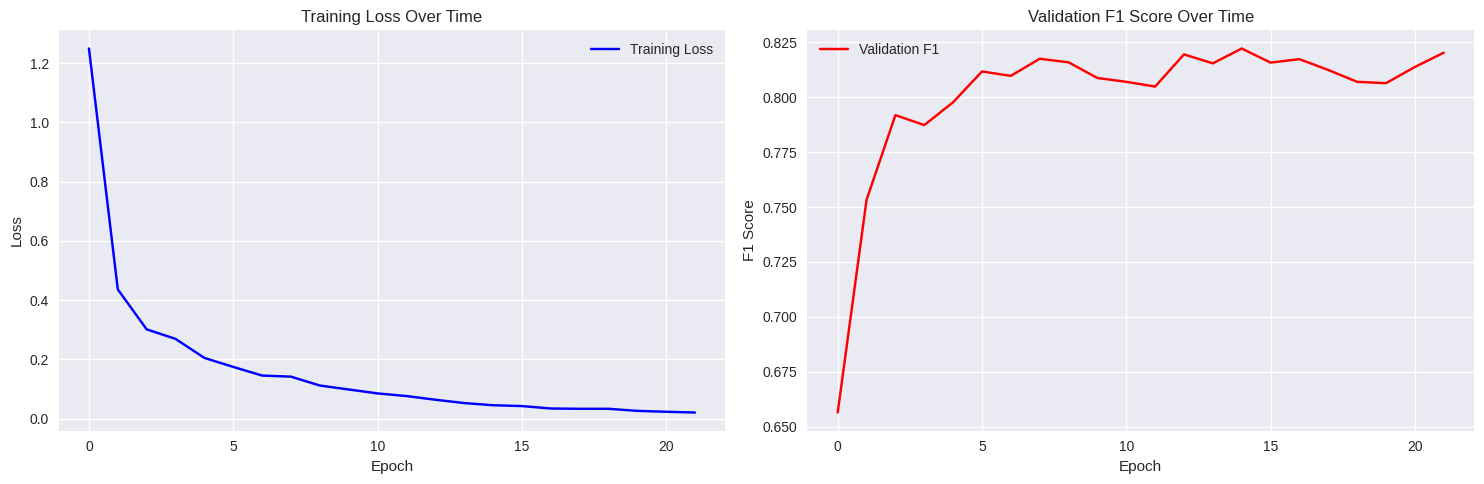


Loaded best model for final evaluation


In [20]:
# Plot training history
plot_training_history(train_losses, val_metrics)

# Load best model for final evaluation
best_model_path = os.path.join(OUTPUT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    if has_tpu:
        model.load_state_dict(torch.load(best_model_path, map_location='cpu'))
    else:
        model.load_state_dict(torch.load(best_model_path))
    print("\nLoaded best model for final evaluation")

In [21]:
# Final evaluation
print("\nPerforming final evaluation...")
final_f1 = evaluate_model(model, val_loader, device, plot_results=True)
print(f"\nFinal Validation F1 Score: {final_f1:.4f}")


Performing final evaluation...


Evaluating: 100%|██████████| 110/110 [00:12<00:00,  8.66it/s]



Per-class Metrics:
--------------------------------------------------
Class        Accuracy  Precision     Recall         F1
--------------------------------------------------
person          0.926      0.939      0.881      0.909
car             0.944      0.754      0.685      0.718
dog             0.973      0.901      0.797      0.846
chair           0.926      0.639      0.662      0.651
bird            0.988      0.942      0.871      0.905
tvmonitor       0.984      0.889      0.782      0.832
motorbike       0.985      0.939      0.737      0.826
bus             0.993      0.938      0.848      0.891
--------------------------------------------------
Average Metrics:
Accuracy:  0.965
Precision: 0.868
Recall:    0.783
F1-Score:  0.822

Final Validation F1 Score: 0.8221



Displaying sample predictions...


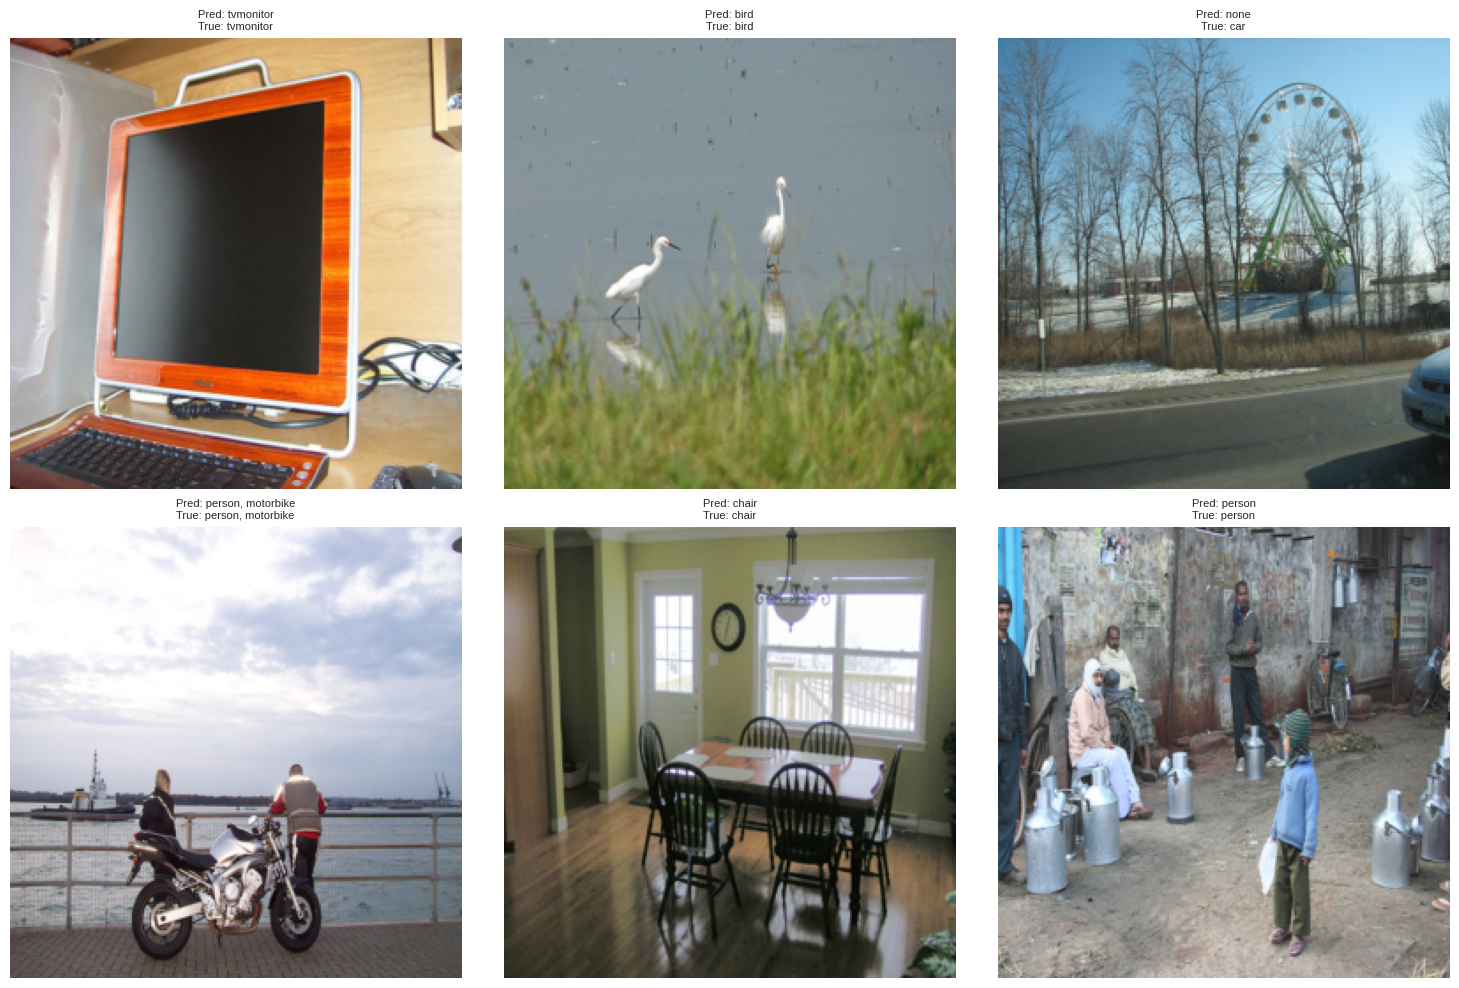

In [25]:
# Display some predictions
print("\nDisplaying sample predictions...")
display_predictions(model, val_loader, device)